# Урок: Рекуррентные нейронные сети

## Задание: 

* Попробуйте изменить параметры нейронной сети, работающей с датасетом imdb, либо нейронной сети, работающей airline-passengers (она прилагается вместе с датасетом к уроку в виде отдельного скрипта) так, чтобы улучшить её точность. Приложите анализ

## Импорт библиотек

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Датасет

### Ссылка: [Kaggle. Daily Climate time series data](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)

### Описание:
The Dataset is fully dedicated for the developers who want to train the model on Weather Forecasting for Indian climate. This dataset provides data from 1st January 2013 to 24th April 2017 in the city of Delhi, India.
The 4 parameters here are:

* meantemp
* humidity
* wind_speed
* meanpressure


In [46]:
drive.mount('/content/drive')

df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/DailyDelhiClimateTrain.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/DailyDelhiClimateTest.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
df_train.sort_values(by='date', ascending=False).head()

,date,meantemp,humidity,wind_speed,meanpressure
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217


In [48]:
df_test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


Последнее наблюдение из train пересекается с test, необходимо его удалить.

In [49]:
df_train = df_train.loc[:1460,:]
df_train.loc[:1460,:].sort_values(by='date', ascending=False).head()

,date,meantemp,humidity,wind_speed,meanpressure
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1456,2016-12-27,16.850000,67.550000,8.335000,1017.200000


## Трансформация данных

* Оставляем только признак среднесуточной температуры `meantemp`
* Применяем к нему StandartScaler()

In [50]:
def transform(df: pd.DataFrame) -> pd.DataFrame:
  df_ = df.copy()
  df_.index = df_.date
  df_.drop(['date', 'humidity', 'wind_speed', 'meanpressure'], axis=1, inplace=True)
  return df_


df_train_proc = transform(df_train)
df_test_proc = transform(df_test)

f = 'meantemp'
std_scaler = StandardScaler()
df_train_proc[f] = std_scaler.fit_transform(df_train_proc[[f]])
df_test_proc[f] = std_scaler.transform(df_test_proc[[f]])

# сбрасываем индекс у train и test
df_train_proc.reset_index(drop=True, inplace=True)
df_test_proc.reset_index(drop=True, inplace=True)

# индексируем test, начиная с последнего индекса train
ind = df_train_proc.index[-1] + 1
df_test_proc.index += ind

In [51]:
df_train_proc.tail()

,meantemp
1456,-1.179807
1457,-1.129732
1458,-1.399505
1459,-1.555273
1460,-1.424783


In [52]:
df_test_proc.head()

,meantemp
1461,-1.307511
1462,-0.954916
1463,-1.144218
1464,-0.927657
1465,-0.970060


## Визуализация данных

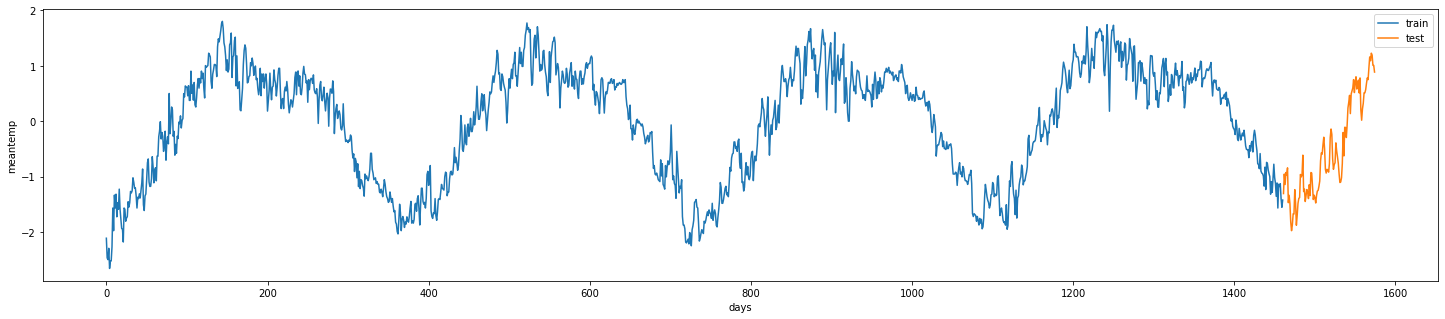

In [53]:
X_train, y_train = df_train_proc, df_train_proc['meantemp']
X_test, y_test = df_test_proc, df_test_proc['meantemp']

plt.figure(figsize=(25,5))
plt.plot(X_train.index, y_train, label='train')
plt.plot(X_test.index, y_test, label='test')

plt.xlabel('days')
plt.ylabel('meantemp')
plt.legend()
plt.show()

## 

In [54]:
X_LEN = 30
BATCH_SIZE = 32
EPOCHS = 100

train_data = keras.preprocessing.timeseries_dataset_from_array(
  X_train,
  y_train,
  sequence_length=X_LEN,
  sampling_rate=1,
  batch_size=BATCH_SIZE,
)

val_data = keras.preprocessing.timeseries_dataset_from_array(
  X_test,
  y_test,
  sequence_length=X_LEN,
  sampling_rate=1,
  batch_size=BATCH_SIZE,
)

## Конфигурация модели

In [55]:
callbaсk_early_stopping = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()
model.add(LSTM(64, input_shape = (30, 1), return_sequences="True"))
model.add(LSTM(64, return_sequences="True"))
model.add(Conv1D(64, 3, activation="linear"))
model.add(Conv1D(64, 1, activation="linear"))
model.add(Flatten())
model.add(Dense(32, activation="linear"))
model.add(Dense(1, activation="linear"))

model.compile(
  loss="mse",
  optimizer="sgd",
  metrics=['mae']
)

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 30, 64)            16896     
_________________________________________________________________
lstm_21 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 28, 64)            12352     
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 28, 64)            4160      
_________________________________________________________________
flatten_10 (Flatten)         (None, 1792)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                57376     
_________________________________________________________________
dense_23 (Dense)             (None, 1)               

## Обучение

Epoch 1/100
45/45 [==============================] - 3s 25ms/step - loss: 0.2095 - mae: 0.3320 - val_loss: 0.3612 - val_mae: 0.4986
Epoch 2/100
45/45 [==============================] - 1s 12ms/step - loss: 0.1117 - mae: 0.2619 - val_loss: 0.1803 - val_mae: 0.3511
Epoch 3/100
45/45 [==============================] - 1s 12ms/step - loss: 0.0823 - mae: 0.2216 - val_loss: 0.1226 - val_mae: 0.2883
Epoch 4/100
45/45 [==============================] - 1s 12ms/step - loss: 0.0721 - mae: 0.2065 - val_loss: 0.1041 - val_mae: 0.2658
Epoch 5/100
45/45 [==============================] - 1s 12ms/step - loss: 0.0678 - mae: 0.2001 - val_loss: 0.0956 - val_mae: 0.2555
Epoch 6/100
45/45 [==============================] - 1s 12ms/step - loss: 0.0650 - mae: 0.1961 - val_loss: 0.0898 - val_mae: 0.2480
Epoch 7/100
45/45 [==============================] - 1s 12ms/step - loss: 0.0629 - mae: 0.1929 - val_loss: 0.0850 - val_mae: 0.2412
Epoch 8/100
45/45 [==============================] - 1s 12ms/step - loss: 0.

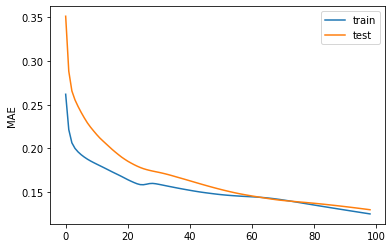

In [56]:
history = model.fit(
  train_data,
  epochs=EPOCHS,
  validation_data=val_data,
  callbacks=[callbaсk_early_stopping]
)

plt.plot(history.history['mae'][1:], label='train')
plt.plot(history.history['val_mae'][1:], label='test')
plt.ylabel('MAE')
plt.legend()
plt.show()

## Проверка модели

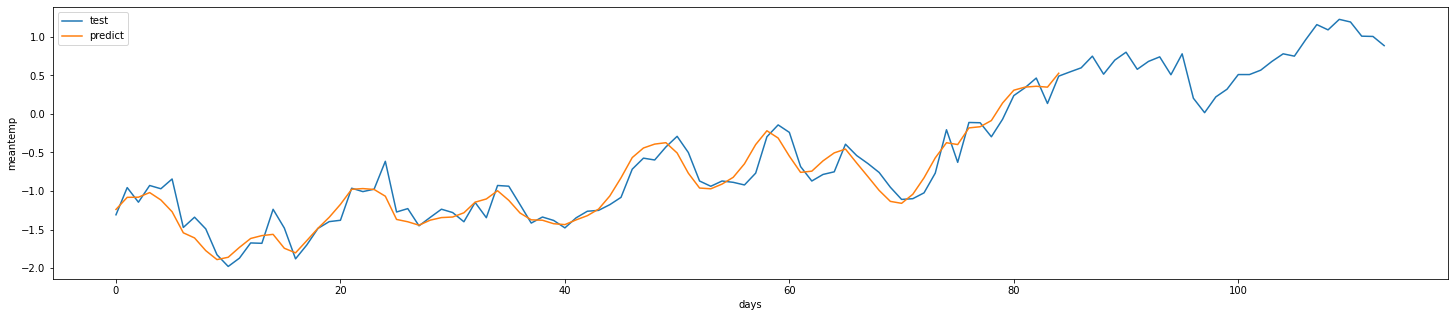

In [57]:
predVal = model.predict(val_data).flatten()

plt.figure(figsize=(25,5))
plt.plot(X_test['meantemp'].to_numpy(), label='test')
plt.plot(predVal, label='predict')

plt.xlabel('days')
plt.ylabel('meantemp')
plt.legend()
plt.show()

## Проверка лаговой корреляции

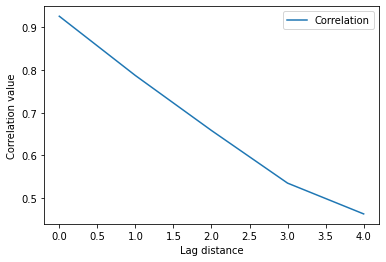

In [58]:
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val


corr = []
start = 0 # начальная точка для проверки корреляций рядов
step = 80 # число точек для проверки корреляций рядов

yValF = y_test[start:start+step] # ряд истиных значений
yPredVal = predVal[start:start+step] # ряд предсказаний 

for i in range(5):
  corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))
  
plt.plot(corr, label='Correlation')
plt.xlabel('Lag distance')
plt.ylabel('Correlation value')
plt.legend()
plt.show()